# آماده‌سازی داده‌ها

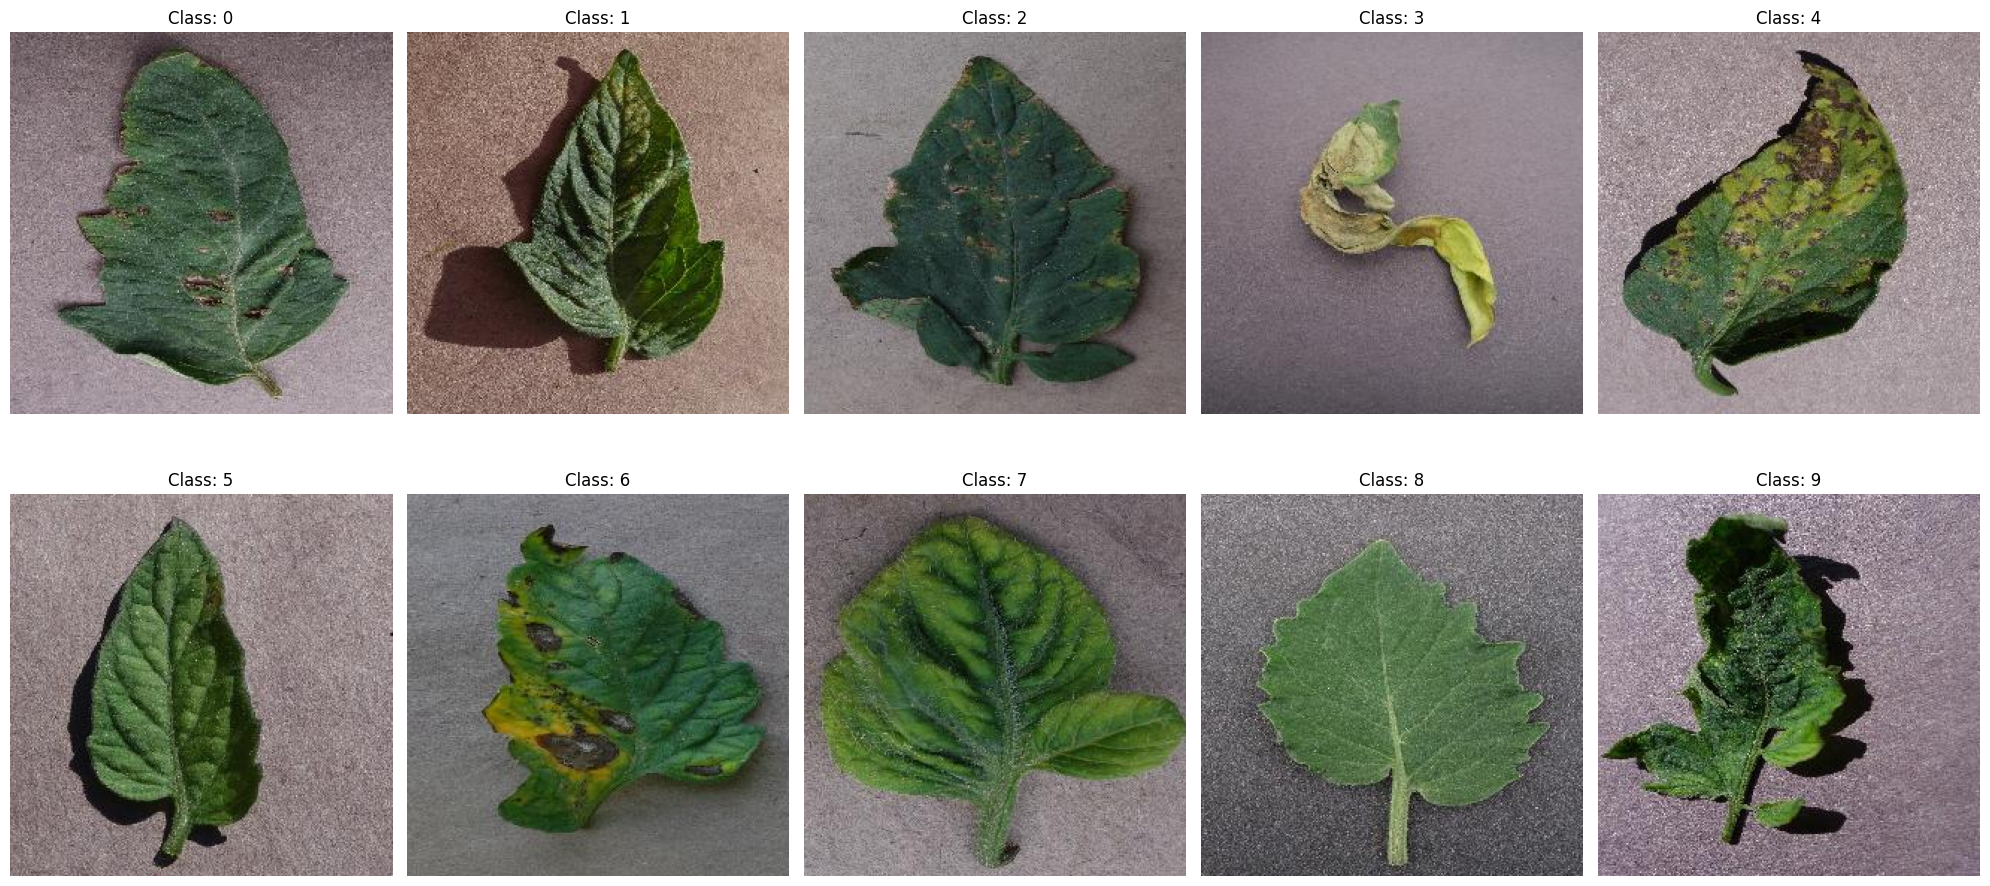

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import io

df=pd.read_parquet('../input/vit-nndl/train-00000-of-00001-982530f49cf10cee.parquet')

first_images_df=df.drop_duplicates(subset=['label'],keep='first').sort_values('label').reset_index(drop=True)

fig,axes=plt.subplots(2,5,figsize=(20,10))
axes=axes.flatten()

for i,row in first_images_df.iterrows():
    label=row['label']
    image_bytes=row['image']['bytes']

    image=Image.open(io.BytesIO(image_bytes))
    ax=axes[i]
    ax.imshow(image)
    ax.set_title(f"Class: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [2]:
class_counts=df['label'].value_counts().sort_index()
class_counts_df=class_counts.reset_index()
class_counts_df.columns=['Class Label','Number of Images']

print(class_counts_df)

   Class Label  Number of Images
0            0              1000
1            1              1000
2            2              1000
3            3              1000
4            4              1000
5            5               952
6            6              1000
7            7              1000
8            8              1000
9            9               373


In [4]:
import tensorflow as tf
data_augmentation=tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
])

augmented_images=[]
target_count=1000
minority_classes=[5,9]

for label in minority_classes:
    class_df=df[df['label']==label]
    current_count=len(class_df)
    n_needed=target_count-current_count

    if n_needed<=0:
        print(f"\nClass {label} already has enough samples.")
        continue

    print(f"\nAugmenting Class {label}. Needing {n_needed} more images.")

    minority_images_bytes=class_df['image'].apply(lambda x: x['bytes']).tolist()

    for i in range(n_needed):
        random_index=i%len(minority_images_bytes)
        img_bytes=minority_images_bytes[random_index]

        img=tf.io.decode_jpeg(img_bytes,channels=3)
        img=tf.expand_dims(img,0)
        augmented_img_tensor=data_augmentation(img)
        augmented_img_tensor=tf.squeeze(augmented_img_tensor,[0])
        augmented_img_tensor=tf.cast(augmented_img_tensor,tf.uint8)

        augmented_images.append({
            'image':{'bytes':tf.io.encode_jpeg(augmented_img_tensor).numpy()},
            'label':label
        })

if augmented_images:
    augmented_df=pd.DataFrame(augmented_images)
    balanced_df=pd.concat([df,augmented_df],ignore_index=True)
else:
    balanced_df=df

print("\nNew, Balanced Class Distribution:")
print(balanced_df['label'].value_counts().sort_index())


Augmenting Class 5. Needing 48 more images.

Augmenting Class 9. Needing 627 more images.

New, Balanced Class Distribution:
label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64


In [5]:
original_image_bytes=df.iloc[0]['image']['bytes']
pil_image=Image.open(io.BytesIO(original_image_bytes))
print(f"Shape of a sample original image (Width, Height):{pil_image.size}")

def resize_image(image_dict):
    img=tf.io.decode_jpeg(image_dict['bytes'],channels=3)
    resized_img=tf.image.resize(img,[64,64])
    resized_img=tf.cast(resized_img,tf.uint8)
    return {'bytes': tf.io.encode_jpeg(resized_img).numpy()}

print("\nResizing all images to 64x64... This may take a moment.")


resized_images_series=balanced_df['image'].apply(resize_image)

resized_df=pd.DataFrame({
    'image':resized_images_series,
    'label':balanced_df['label']
})

print("Resizing complete.")

resized_image_bytes=resized_df.iloc[0]['image']['bytes']
pil_resized_image=Image.open(io.BytesIO(resized_image_bytes))
print(f"Shape of a sample image in 'resized_df' (Width, Height): {pil_resized_image.size}")

Shape of a sample original image (Width, Height):(256, 256)

Resizing all images to 64x64... This may take a moment.
Resizing complete.
Shape of a sample image in 'resized_df' (Width, Height): (64, 64)


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
print("Splitting the 64x64 resized data...")
X_resized=resized_df['image']
y_resized=resized_df['label']

x_train_resized_series,x_val_resized_series,y_train_resized,y_val_resized=train_test_split(
    X_resized,y_resized,test_size=0.2,random_state=42,stratify=y_resized)

print("Splitting the original-sized balanced data...")
X_balanced=balanced_df['image']
y_balanced=balanced_df['label']

x_train_balanced_series,x_val_balanced_series,y_train_balanced,y_val_balanced=train_test_split(
    X_balanced,y_balanced,test_size=0.2,random_state=42,stratify=y_balanced)

def convert_to_numpy_array(image_series):
    images=[tf.io.decode_jpeg(d['bytes'],channels=3).numpy() for d in image_series]
    return np.array(images)

print("\nConverting data to NumPy format for model training...")

x_train_resized=convert_to_numpy_array(x_train_resized_series)
x_val_resized=convert_to_numpy_array(x_val_resized_series)

x_train_balanced=convert_to_numpy_array(x_train_balanced_series)
x_val_balanced=convert_to_numpy_array(x_val_balanced_series)

print("\nData preparation complete! Here are the shapes for the resized (64x64) dataset:")
print(f"x_train_resized shape: {x_train_resized.shape}")
print(f"y_train_resized shape: {y_train_resized.shape}")
print(f"x_val_resized shape:   {x_val_resized.shape}")
print(f"y_val_resized shape:   {y_val_resized.shape}")

Splitting the 64x64 resized data...
Splitting the original-sized balanced data...

Converting data to NumPy format for model training...

Data preparation complete! Here are the shapes for the resized (64x64) dataset:
x_train_resized shape: (8000, 64, 64, 3)
y_train_resized shape: (8000,)
x_val_resized shape:   (2000, 64, 64, 3)
y_val_resized shape:   (2000,)


# آموزش مدل CNN

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

INPUT_SHAPE=(256,256,3)  
NUM_CLASSES=10          

base_model=InceptionV3(
    weights=None,
    include_top=False,
    input_shape=INPUT_SHAPE)

model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
print("Custom InceptionV3 Model Summary:")
model.summary()

Custom InceptionV3 Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 21,788,842 (83.12 MB)

 Non-trainable params: 34,432 (134.50 KB)

Starting model training...
Epoch 1/30


I0000 00:00:1749662346.842629     110 service.cc:148] XLA service 0x1c5bb580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749662346.843610     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749662346.843630     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749662351.904787     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749662383.915039     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 372ms/step - accuracy: 0.4825 - loss: 1.6298 - val_accuracy: 0.3385 - val_loss: 2.8679 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - accuracy: 0.7478 - loss: 0.7770 - val_accuracy: 0.3920 - val_loss: 2.6922 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 318ms/step - accuracy: 0.8201 - loss: 0.5405 - val_accuracy: 0.4845 - val_loss: 2.4680 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 318ms/step - accuracy: 0.8450 - loss: 0.4321 - val_accuracy: 0.7705 - val_loss: 0.7900 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 318ms/step - accuracy: 0.8633 - loss: 0.4015 - val_accuracy: 0.7255 - val_loss: 1.0913 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.8956 - loss: 0.3010 - val_accuracy: 0.6810 - val_loss: 1.3389 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.9232 - loss

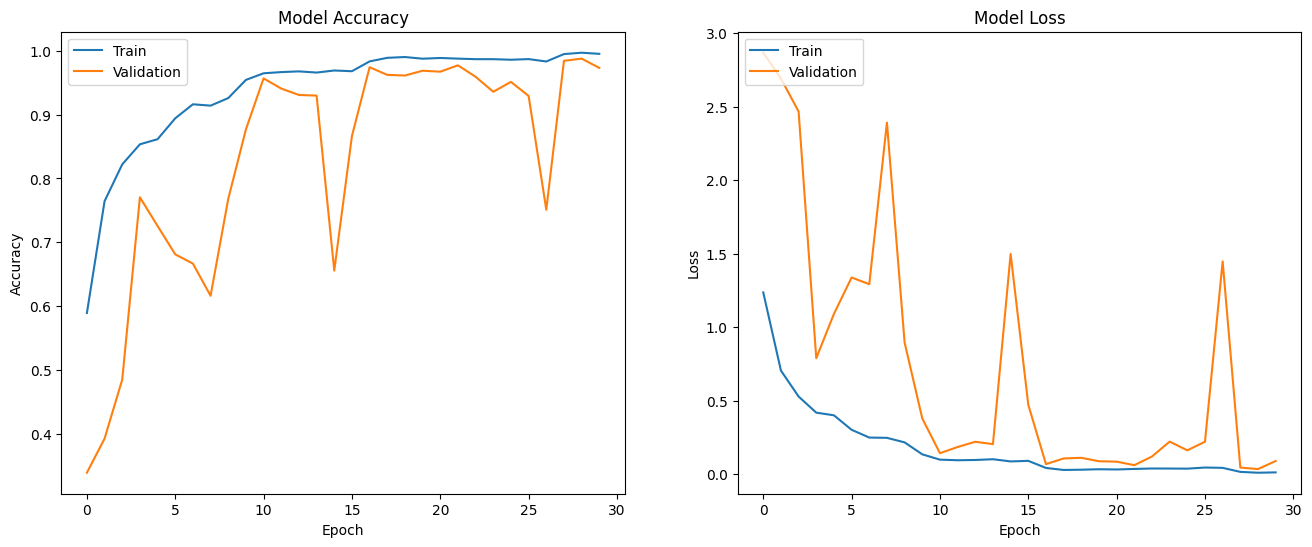

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lr_scheduler=ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,    
    min_lr=0.00001)

print("Starting model training...")
history=model.fit(
    x_train_balanced,
    y_train_balanced,
    epochs=30,
    validation_data=(x_val_balanced,y_val_balanced),
    callbacks=[lr_scheduler]
)
print("Model training complete.")

fig,axes=plt.subplots(1,2,figsize=(16,6))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train','Validation'],loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step


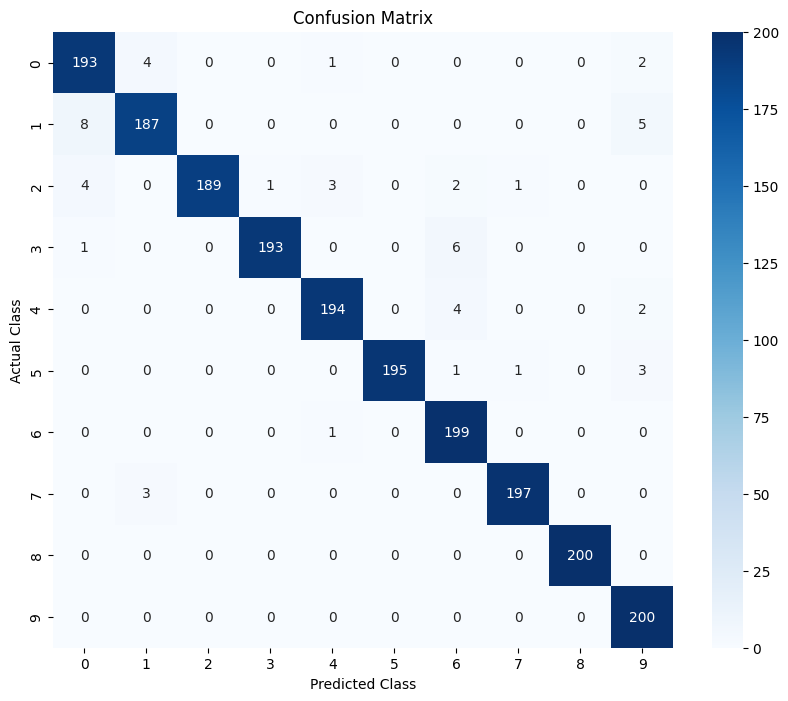

In [9]:
y_pred_probs=model.predict(x_val_balanced)
y_pred_classes=np.argmax(y_pred_probs,axis=1)
cm=confusion_matrix(y_val_balanced,y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=range(NUM_CLASSES),
            yticklabels=range(NUM_CLASSES))
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# آموزش مدل ViT

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

TARGET_IMAGE_SIZE=80
PATCH_SIZE=8

INPUT_SHAPE=(64,64,3) 
NUM_PATCHES=(TARGET_IMAGE_SIZE//PATCH_SIZE)**2
PROJECTION_DIM=64
NUM_HEADS=16
TRANSFORMER_LAYERS=2
MLP_UNITS=[PROJECTION_DIM *2,PROJECTION_DIM]
NUM_CLASSES=10

class Patches(layers.Layer):
    def __init__(self,patch_size):
        super().__init__()
        self.patch_size=patch_size
    def call(self,images):
        batch_size=tf.shape(images)[0]
        patches=tf.image.extract_patches(
            images=images,
            sizes=[1,self.patch_size,self.patch_size,1],
            strides=[1,self.patch_size,self.patch_size,1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self,num_patches,projection_dim):
        super().__init__()
        self.num_patches=num_patches
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding=layers.Embedding(
            input_dim=num_patches,output_dim=projection_dim)
    def call(self, patch):
        positions=tf.range(start=0,limit=self.num_patches,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded

def create_vit_model():
    inputs=layers.Input(shape=INPUT_SHAPE)

    resized_images=layers.Resizing(TARGET_IMAGE_SIZE,TARGET_IMAGE_SIZE)(inputs)

    patches=Patches(PATCH_SIZE)(resized_images)

    encoded_patches=PatchEncoder(NUM_PATCHES,PROJECTION_DIM)(patches)

    for _ in range(TRANSFORMER_LAYERS):
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(
            num_heads=NUM_HEADS,key_dim=PROJECTION_DIM,dropout=0.1)(x1,x1)
        x2=layers.Add()([attention_output,encoded_patches])
        x3=layers.LayerNormalization(epsilon=1e-6)(x2)
        x3=layers.Dense(units=MLP_UNITS[0], activation=tf.nn.gelu)(x3)
        x3=layers.Dropout(0.1)(x3)
        x3=layers.Dense(units=MLP_UNITS[1])(x3)
        x3=layers.Dropout(0.1)(x3)
        layer_name="transformer_output" if i==TRANSFORMER_LAYERS-1 else None
        encoded_patches=layers.Add()([x3,x2])

    representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation=layers.Flatten()(representation) 
    representation=layers.Dropout(0.5)(representation)
    features=layers.Dense(2048,activation="relu")(representation)
    features=layers.Dropout(0.5)(features)
    features=layers.Dense(1024,activation="relu")(features)
    features=layers.Dropout(0.5)(features)
    outputs=layers.Dense(NUM_CLASSES,activation="softmax")(features)
    
    model=keras.Model(inputs=inputs,outputs=outputs)
    return model

vit_model=create_vit_model()
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("Final ViT Model Summary (Replicating Article's Table 4):")
vit_model.summary()

Final ViT Model Summary (Replicating Article's Table 4):


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_6 (Resizing)     │ (None, 80, 80, 3)      │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_6 (Patches)       │ (None, None, 192)      │              0 │ resizing_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_6           │ (None, 100, 64)        │         18,752 │ patches_6[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_30    │ (None, 100, 64)        │            128 │ patch_encoder_6[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 100, 64)        │        265,280 │ layer_normalization_3… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 100, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_31    │ (None, 100, 64)        │            128 │ add_24[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 100, 128)       │          8,320 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_55 (Dropout)      │ (None, 100, 128)       │              0 │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 100, 64)        │          8,256 │ dropout_55[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_56 (Dropout)      │ (None, 100, 64)        │              0 │ dense_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 100, 64)        │              0 │ dropout_56[0][0],      │
│                           │                        │                │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_32    │ (None, 100, 64)        │            128 │ add_25[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 100, 64)        │        265,280 │ layer_normalization_3… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_3… │
├──────────────────────

 Total params: 15,800,778 (60.28 MB)

 Trainable params: 15,800,778 (60.28 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_509']
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


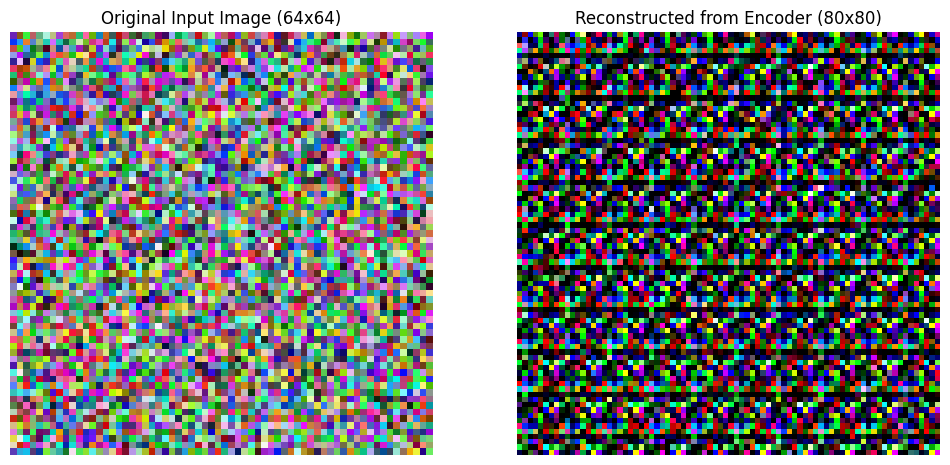

In [33]:
encoder_output_layer=vit_model.layers[-9] 
encoder_model=keras.Model(
    inputs=vit_model.inputs,
    outputs=encoder_output_layer.output)

reconstruction_head=keras.Sequential([
    layers.Dense(PATCH_SIZE*PATCH_SIZE*3),
    layers.Reshape((NUM_PATCHES,PATCH_SIZE,PATCH_SIZE,3))
], name="reconstruction_head")


dummy_image=np.random.rand(1,64,64,3)

encoded_patches=encoder_model.predict(dummy_image)

reconstructed_patches_grid=reconstruction_head(encoded_patches)

reconstructed_patches_grid=np.reshape(reconstructed_patches_grid, (1,10,10,PATCH_SIZE,PATCH_SIZE,3))
reconstructed_image=np.transpose(reconstructed_patches_grid, (0,1,3,2,4,5))
reconstructed_image=np.reshape(reconstructed_image,(1,TARGET_IMAGE_SIZE,TARGET_IMAGE_SIZE,3))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original Input Image (64x64)")
plt.imshow(dummy_image[0])
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Reconstructed from Encoder (80x80)")
plt.imshow(np.clip(reconstructed_image[0],0,1))
plt.axis('off')

plt.show()

Starting ViT model training...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.1093 - loss: 4.5227 - val_accuracy: 0.1110 - val_loss: 2.2847
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1264 - loss: 2.2653 - val_accuracy: 0.1680 - val_loss: 2.1656
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1685 - loss: 2.1865 - val_accuracy: 0.2365 - val_loss: 2.1034
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1694 - loss: 2.1797 - val_accuracy: 0.3070 - val_loss: 1.9908
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.2194 - loss: 2.0691 - val_accuracy: 0.3530 - val_loss: 1.8244
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2516 - loss: 2.0117 - val_accuracy: 0.4120 - val_loss: 1.6490
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3244 - loss: 1.8465 - val_accuracy: 0.4960 - val_loss: 1.4634
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 

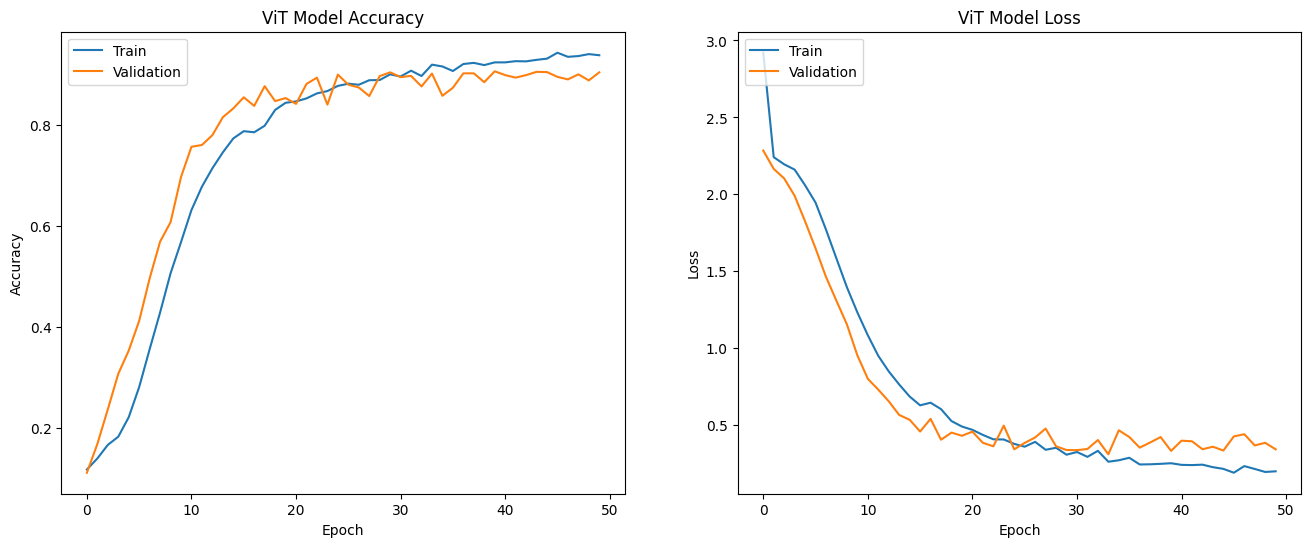

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

print("Starting ViT model training...")
history=vit_model.fit(
    x_train_resized,
    y_train_resized,
    epochs=50,
    validation_data=(x_val_resized,y_val_resized),
)
print("ViT model training complete.")

fig,axes=plt.subplots(1,2,figsize=(16,6))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('ViT Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train','Validation'],loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('ViT Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train','Validation'],loc='upper left')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


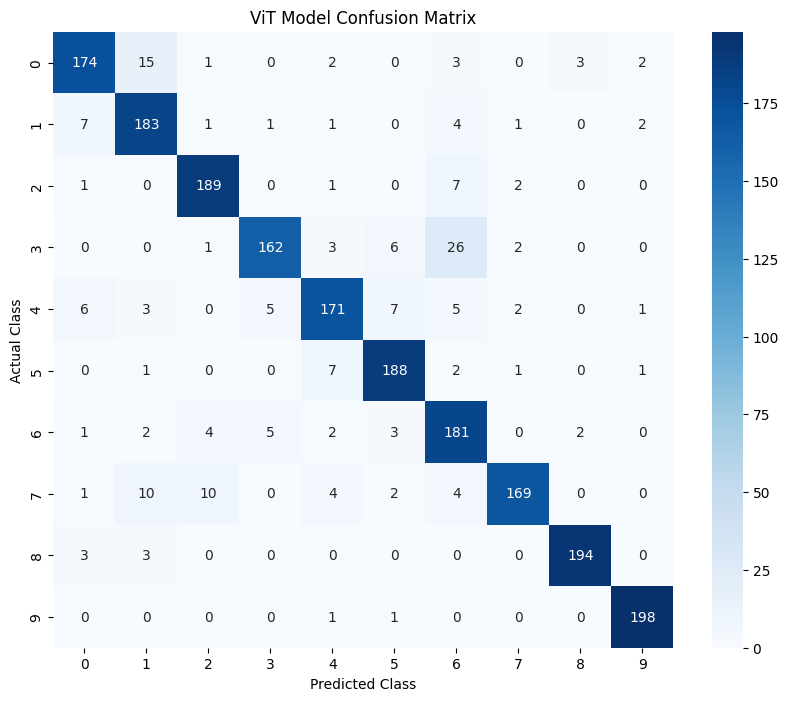

In [23]:
y_pred_probs=vit_model.predict(x_val_resized)
y_pred_classes=np.argmax(y_pred_probs,axis=1)

cm=confusion_matrix(y_val_resized,y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=range(NUM_CLASSES),
            yticklabels=range(NUM_CLASSES))
plt.title('ViT Model Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# تحلیل و نتیجه گیری

In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

inception_pred_probs=model.predict(x_val_balanced)
inception_pred_classes=np.argmax(inception_pred_probs,axis=1)

print("\nInceptionV3 Classification Report:")
print(classification_report(y_val_balanced,inception_pred_classes,
                            target_names=[f"Class {i}" for i in range(10)]))


vit_pred_probs=vit_model.predict(x_val_resized)
vit_pred_classes=np.argmax(vit_pred_probs,axis=1)

print("\nViT Classification Report:")
print(classification_report(y_val_resized,vit_pred_classes,
                            target_names=[f"Class {i}" for i in range(10)]))

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step

InceptionV3 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.96      0.95       200
     Class 1       0.96      0.94      0.95       200
     Class 2       1.00      0.94      0.97       200
     Class 3       0.99      0.96      0.98       200
     Class 4       0.97      0.97      0.97       200
     Class 5       1.00      0.97      0.99       200
     Class 6       0.94      0.99      0.97       200
     Class 7       0.99      0.98      0.99       200
     Class 8       1.00      1.00      1.00       200
     Class 9       0.94      1.00      0.97       200

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

ViT Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.87      0.89